**Imports**

In [1]:
# Imports
import pandas as pd
import os
import seaborn as sns
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, pearsonr, spearmanr, kendalltau, f_oneway, kruskal
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np

cwd = os.getcwd() # Get current directory

In [2]:
print(cwd)

C:\Users\lirik\Desktop\RGR Analysis\scripts


**Data Wrangling and Exploration**

In [3]:
# Load CSV as pandas dataframe
df_path = cwd + "\\data\\rgr_data_test.csv" # Filepath to data
df_rgr = pd.read_csv(df_path) # dataframe of rgr.csv data

display(df_rgr.head(5)) # check output

,RIDER_ID,LOCATION,APPLICATION_DATE,APPLICATION_APPROVED_DATE,FIRST_WORK_DATE,ACQUISITION_CHANNEL,VEHICLE_TYPE,DAYS_SINCE_ACQUISITION,HOURS_WORKED_CUMULATIVE,ORDERS_DELIVERED_CUMULATIVE,THROUGHPUT_CUMULATIVE,REFERRALS_CUMULATIVE,SUCCESSFUL_REFERRALS_CUMULATIVE
0,73350,Roo de Janeiro,2016-10-29 00:00:00.000000000,2016-11-07 00:00:00.000000000,2016-11-09,Organic,Bicycle,7,11.9,12,1.01,NaN,NaN
1,73350,Roo de Janeiro,2016-10-29 00:00:00.000000000,2016-11-07 00:00:00.000000000,2016-11-09,Organic,Bicycle,14,13.1,13,0.99,NaN,NaN
2,73350,Roo de Janeiro,2016-10-29 00:00:00.000000000,2016-11-07 00:00:00.000000000,2016-11-09,Organic,Bicycle,28,19.1,20,1.04,NaN,NaN
3,73350,Roo de Janeiro,2016-10-29 00:00:00.000000000,2016-11-07 00:00:00.000000000,2016-11-09,Organic,Bicycle,56,33.4,39,1.17,NaN,NaN
4,73350,Roo de Janeiro,2016-10-29 00:00:00.000000000,2016-11-07 00:00:00.000000000,2016-11-09,Organic,Bicycle,84,33.4,39,1.17,NaN,NaN


In [4]:
# Basic description of data

print("Non-Null Counts:")
df_rgr.info()
print("-----------------------------------------")

print("Duplicate Rows:")
df_rgr[df_rgr.duplicated()]
print("-----------------------------------------")

print("Unique Values:")
print(df_rgr.nunique())

print("-----------------------------------------")
print("Descriptive Statistics:")
print(df_rgr.describe([0, 0.05, 0.50, 0.95, 0.99, 1]))

Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31038 entries, 0 to 31037
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   RIDER_ID                         31038 non-null  int64  
 1   LOCATION                         31038 non-null  object 
 2   APPLICATION_DATE                 30024 non-null  object 
 3   APPLICATION_APPROVED_DATE        30078 non-null  object 
 4   FIRST_WORK_DATE                  31038 non-null  object 
 5   ACQUISITION_CHANNEL              31038 non-null  object 
 6   VEHICLE_TYPE                     31038 non-null  object 
 7   DAYS_SINCE_ACQUISITION           31038 non-null  int64  
 8   HOURS_WORKED_CUMULATIVE          31038 non-null  float64
 9   ORDERS_DELIVERED_CUMULATIVE      31038 non-null  int64  
 10  THROUGHPUT_CUMULATIVE            31038 non-null  float64
 11  REFERRALS_CUMULATIVE             4056 non-null   float64
 12  S

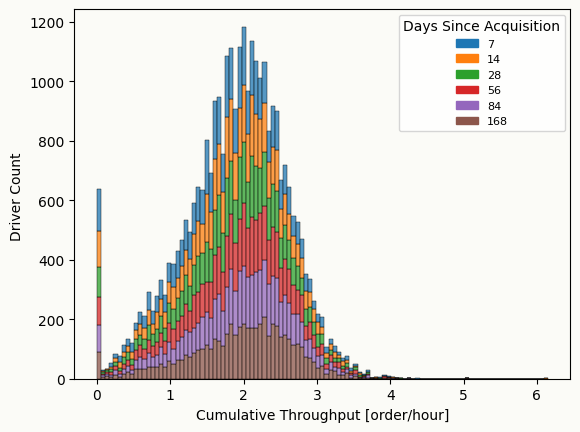

In [5]:
# Plot distribution of raw data

ax = sns.histplot(df_rgr, x="THROUGHPUT_CUMULATIVE", hue="DAYS_SINCE_ACQUISITION", multiple="stack", palette="tab10", fill=True)

# Create legend
unique_values = sorted(df_rgr["DAYS_SINCE_ACQUISITION"].unique())  # Ensure sorted order for consistency
colors = sns.color_palette("tab10", len(unique_values))  # Generate colors

# Label Axis
ax.set(xlabel='Cumulative Throughput [order/hour]', ylabel='Driver Count ')

# Create custom legend patches
legend_patches = [Patch(color=colors[i], label=str(val)) for i, val in enumerate(unique_values)]

plt.gcf().set_facecolor('#fbfbf7')  
ax.set_facecolor('#fbfbf7')

# Add the legend
ax.legend(handles=legend_patches, title="Days Since Acquisition", loc="upper right", fontsize = 8)

**Edge Case  / Irregularity Testing**

Irregularities to explore:
1. See if application dates are chornologically consistent
2. See if referral counts are consistent
3. Drastic increase beween 99th and 100th percentile for throughput, referrals, and succesful referrals.
4. Understand effect of zero order drivers

In [6]:
print("t-value throughput:")
conf_int1 = sms.DescrStatsW(df_rgr['THROUGHPUT_CUMULATIVE']).tconfint_mean()
print(conf_int1)

t-value throughput:
(np.float64(1.8662168809143111), np.float64(1.8818996214376449))


1. See if application dates are chronologically consistent

In [7]:
# See if drivers are registered as working when either application or approval is not found

null_mask = df_rgr['APPLICATION_DATE'].isnull() | df_rgr['APPLICATION_APPROVED_DATE'].isnull()
null_rows = df_rgr[null_mask]

df_rgr_nulls = df_rgr[null_mask]

not_null_mask = df_rgr_nulls['FIRST_WORK_DATE'].notnull()
anomaly_dates = df_rgr_nulls[not_null_mask]

anomaly_dates

,RIDER_ID,LOCATION,APPLICATION_DATE,APPLICATION_APPROVED_DATE,FIRST_WORK_DATE,ACQUISITION_CHANNEL,VEHICLE_TYPE,DAYS_SINCE_ACQUISITION,HOURS_WORKED_CUMULATIVE,ORDERS_DELIVERED_CUMULATIVE,THROUGHPUT_CUMULATIVE,REFERRALS_CUMULATIVE,SUCCESSFUL_REFERRALS_CUMULATIVE
187,100482,Roo York,NaN,NaN,2017-03-14,Unknown,Bicycle,7,7.5,20,2.66,NaN,NaN
188,100482,Roo York,NaN,NaN,2017-03-14,Unknown,Bicycle,14,7.5,20,2.66,NaN,NaN
189,100482,Roo York,NaN,NaN,2017-03-14,Unknown,Bicycle,28,13.6,34,2.50,NaN,NaN
190,100482,Roo York,NaN,NaN,2017-03-14,Unknown,Bicycle,56,13.6,34,2.50,NaN,NaN
191,100482,Roo York,NaN,NaN,2017-03-14,Unknown,Bicycle,84,13.6,34,2.50,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29747,99562,Roo York,NaN,NaN,2017-03-22,Unknown,Scooter / Motorcycle,84,105.1,293,2.79,NaN,NaN
29748,99562,Roo York,NaN,NaN,2017-03-22,Unknown,Scooter / Motorcycle,168,156.1,428,2.74,NaN,NaN
30540,79701,Roo de Janeiro,NaN,NaN,2016-12-02,Unknown,Bicycle,56,367.9,748,2.03,NaN,NaN
30541,79701,Roo de Janeiro,NaN,NaN,2016-12-02,Unknown,Bicycle,84,509.2,1108,2.18,NaN,NaN


All 1014 drivers without an application date or approved date do not have a first work date. As they are not validated drivers, the best course of action would be to flag these driver IDs for future investigation and remove from sample we are considering in our current analysis.

In [8]:
# Drop unvalidated drivers
df_rgr.dropna(subset=['APPLICATION_DATE'], inplace=True)
df_rgr.dropna(subset=['APPLICATION_APPROVED_DATE'], inplace=True)

In [9]:
df_rgr

,RIDER_ID,LOCATION,APPLICATION_DATE,APPLICATION_APPROVED_DATE,FIRST_WORK_DATE,ACQUISITION_CHANNEL,VEHICLE_TYPE,DAYS_SINCE_ACQUISITION,HOURS_WORKED_CUMULATIVE,ORDERS_DELIVERED_CUMULATIVE,THROUGHPUT_CUMULATIVE,REFERRALS_CUMULATIVE,SUCCESSFUL_REFERRALS_CUMULATIVE
0,73350,Roo de Janeiro,2016-10-29 00:00:00.000000000,2016-11-07 00:00:00.000000000,2016-11-09,Organic,Bicycle,7,11.9,12,1.01,NaN,NaN
1,73350,Roo de Janeiro,2016-10-29 00:00:00.000000000,2016-11-07 00:00:00.000000000,2016-11-09,Organic,Bicycle,14,13.1,13,0.99,NaN,NaN
2,73350,Roo de Janeiro,2016-10-29 00:00:00.000000000,2016-11-07 00:00:00.000000000,2016-11-09,Organic,Bicycle,28,19.1,20,1.04,NaN,NaN
3,73350,Roo de Janeiro,2016-10-29 00:00:00.000000000,2016-11-07 00:00:00.000000000,2016-11-09,Organic,Bicycle,56,33.4,39,1.17,NaN,NaN
4,73350,Roo de Janeiro,2016-10-29 00:00:00.000000000,2016-11-07 00:00:00.000000000,2016-11-09,Organic,Bicycle,84,33.4,39,1.17,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31033,101217,Roo York,2017-02-27 00:00:00.000000000,2017-03-18 00:00:00.000000000,2017-03-18,Digital,Scooter / Motorcycle,14,29.6,61,2.06,NaN,NaN
31034,101217,Roo York,2017-02-27 00:00:00.000000000,2017-03-18 00:00:00.000000000,2017-03-18,Digital,Scooter / Motorcycle,28,55.5,123,2.22,NaN,NaN
31035,101217,Roo York,2017-02-27 00:00:00.000000000,2017-03-18 00:00:00.000000000,2017-03-18,Digital,Scooter / Motorcycle,56,62.8,138,2.20,NaN,NaN
31036,101217,Roo York,2017-02-27 00:00:00.000000000,2017-03-18 00:00:00.000000000,2017-03-18,Digital,Scooter / Motorcycle,84,67.1,145,2.16,NaN,NaN


In [10]:
# See if there are invalid dates (i.e., there are drivers who were delivering before Deliveroo started in Feb 2013 or in the future)

print('Minimum Date:')
print(df_rgr['FIRST_WORK_DATE'].min())

print('Maximum Date:')
print(df_rgr['FIRST_WORK_DATE'].max())

Minimum Date:
2016-10-13
Maximum Date:
2017-04-08


2. See if referral counts are consistent

In [11]:
# See if there are any rows where number of successful referals > number of referals

df_rgr.loc[(df_rgr['SUCCESSFUL_REFERRALS_CUMULATIVE'] > df_rgr['REFERRALS_CUMULATIVE'])]

,RIDER_ID,LOCATION,APPLICATION_DATE,APPLICATION_APPROVED_DATE,FIRST_WORK_DATE,ACQUISITION_CHANNEL,VEHICLE_TYPE,DAYS_SINCE_ACQUISITION,HOURS_WORKED_CUMULATIVE,ORDERS_DELIVERED_CUMULATIVE,THROUGHPUT_CUMULATIVE,REFERRALS_CUMULATIVE,SUCCESSFUL_REFERRALS_CUMULATIVE


3. Drastic increase beween 99th and 100th percentile for throughput, referrals, and succesful referrals.

In [12]:
# Deal with outliers by replacing edge cases with lower and upper limits determined from IQR

def outlier_thresholds(dataframe, variable):
    """
    Calculate the lower and upper outlier thresholds for a given variable in the dataframe.

    Parameters:
        dataframe (pandas.DataFrame): The dataframe containing the variable.
        variable (str): The name of the variable for which outlier thresholds will be calculated.

    Returns:
        tuple: A tuple containing the lower and upper outlier thresholds.
    """
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit.round(), up_limit.round()

def replace_with_thresholds(dataframe, variable):
    """
    Replace the outliers in the given variable of the dataframe with the lower and upper thresholds.

    Parameters:
        dataframe (pandas.DataFrame): The dataframe containing the variable.
        variable (str): The name of the variable for which outliers will be replaced.

    Returns:
        None  
    """
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe[variable] = dataframe[variable].apply(
        lambda x: low_limit if x < low_limit else (up_limit if x > up_limit else x)
    )
    return dataframe

In [13]:
replace_with_thresholds(df_rgr,"THROUGHPUT_CUMULATIVE")

,RIDER_ID,LOCATION,APPLICATION_DATE,APPLICATION_APPROVED_DATE,FIRST_WORK_DATE,ACQUISITION_CHANNEL,VEHICLE_TYPE,DAYS_SINCE_ACQUISITION,HOURS_WORKED_CUMULATIVE,ORDERS_DELIVERED_CUMULATIVE,THROUGHPUT_CUMULATIVE,REFERRALS_CUMULATIVE,SUCCESSFUL_REFERRALS_CUMULATIVE
0,73350,Roo de Janeiro,2016-10-29 00:00:00.000000000,2016-11-07 00:00:00.000000000,2016-11-09,Organic,Bicycle,7,11.9,12,1.01,NaN,NaN
1,73350,Roo de Janeiro,2016-10-29 00:00:00.000000000,2016-11-07 00:00:00.000000000,2016-11-09,Organic,Bicycle,14,13.1,13,0.99,NaN,NaN
2,73350,Roo de Janeiro,2016-10-29 00:00:00.000000000,2016-11-07 00:00:00.000000000,2016-11-09,Organic,Bicycle,28,19.1,20,1.04,NaN,NaN
3,73350,Roo de Janeiro,2016-10-29 00:00:00.000000000,2016-11-07 00:00:00.000000000,2016-11-09,Organic,Bicycle,56,33.4,39,1.17,NaN,NaN
4,73350,Roo de Janeiro,2016-10-29 00:00:00.000000000,2016-11-07 00:00:00.000000000,2016-11-09,Organic,Bicycle,84,33.4,39,1.17,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31033,101217,Roo York,2017-02-27 00:00:00.000000000,2017-03-18 00:00:00.000000000,2017-03-18,Digital,Scooter / Motorcycle,14,29.6,61,2.06,NaN,NaN
31034,101217,Roo York,2017-02-27 00:00:00.000000000,2017-03-18 00:00:00.000000000,2017-03-18,Digital,Scooter / Motorcycle,28,55.5,123,2.22,NaN,NaN
31035,101217,Roo York,2017-02-27 00:00:00.000000000,2017-03-18 00:00:00.000000000,2017-03-18,Digital,Scooter / Motorcycle,56,62.8,138,2.20,NaN,NaN
31036,101217,Roo York,2017-02-27 00:00:00.000000000,2017-03-18 00:00:00.000000000,2017-03-18,Digital,Scooter / Motorcycle,84,67.1,145,2.16,NaN,NaN


4. Understand effect of zero order drivers

In [14]:
df_rgr[df_rgr["THROUGHPUT_CUMULATIVE"] == 0]

,RIDER_ID,LOCATION,APPLICATION_DATE,APPLICATION_APPROVED_DATE,FIRST_WORK_DATE,ACQUISITION_CHANNEL,VEHICLE_TYPE,DAYS_SINCE_ACQUISITION,HOURS_WORKED_CUMULATIVE,ORDERS_DELIVERED_CUMULATIVE,THROUGHPUT_CUMULATIVE,REFERRALS_CUMULATIVE,SUCCESSFUL_REFERRALS_CUMULATIVE
205,79934,Roo York,2016-07-23 00:00:00.000000000,2016-12-03 00:00:00.000000000,2016-12-13,Digital,Bicycle,7,0.4,0,0.0,NaN,NaN
206,79934,Roo York,2016-07-23 00:00:00.000000000,2016-12-03 00:00:00.000000000,2016-12-13,Digital,Bicycle,14,0.4,0,0.0,NaN,NaN
217,70188,Roo York,2016-10-14 00:00:00.000000000,2016-10-28 00:00:00.000000000,2016-10-29,Digital,Bicycle,7,1.9,0,0.0,NaN,NaN
218,70188,Roo York,2016-10-14 00:00:00.000000000,2016-10-28 00:00:00.000000000,2016-10-29,Digital,Bicycle,14,1.9,0,0.0,NaN,NaN
839,64905,Roo Town,2016-09-28 00:00:00.000000000,2016-11-04 00:00:00.000000000,2016-10-28,Organic,Scooter / Motorcycle,7,1.1,0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30907,99180,Roo York,2017-02-07 00:00:00.000000000,2017-03-05 00:00:00.000000000,2017-03-09,Offline,Bicycle,14,0.3,0,0.0,NaN,NaN
30908,99180,Roo York,2017-02-07 00:00:00.000000000,2017-03-05 00:00:00.000000000,2017-03-09,Offline,Bicycle,28,0.3,0,0.0,NaN,NaN
30909,99180,Roo York,2017-02-07 00:00:00.000000000,2017-03-05 00:00:00.000000000,2017-03-09,Offline,Bicycle,56,0.3,0,0.0,NaN,NaN
30910,99180,Roo York,2017-02-07 00:00:00.000000000,2017-03-05 00:00:00.000000000,2017-03-09,Offline,Bicycle,84,0.3,0,0.0,NaN,NaN


In [15]:
print("Hours worked mean")
print(df_rgr['HOURS_WORKED_CUMULATIVE'][df_rgr["THROUGHPUT_CUMULATIVE"] == 0].mean())

print("Hours worked median")
print(df_rgr['HOURS_WORKED_CUMULATIVE'][df_rgr["THROUGHPUT_CUMULATIVE"] == 0].median())

print("Days aquisition mean")
print(df_rgr['DAYS_SINCE_ACQUISITION'][df_rgr["THROUGHPUT_CUMULATIVE"] == 0].mean())
print("Days aquisition median")
print(df_rgr['DAYS_SINCE_ACQUISITION'][df_rgr["THROUGHPUT_CUMULATIVE"] == 0].median())

Hours worked mean
2.3518518518518516
Hours worked median
0.9
Days aquisition mean
52.56199677938808
Days aquisition median
28.0


The mean and median of the zero-order drivers is quite low, and make up a small proportion of the driver population (2%). This indicates that these are drivers that have not started or churned. As a result, I will remove them from the analysis.

In [16]:
df_rgr = df_rgr[df_rgr.ORDERS_DELIVERED_CUMULATIVE != 0]

In [17]:
print("t-value throughput:")
conf_int = sms.DescrStatsW(df_rgr['THROUGHPUT_CUMULATIVE']).tconfint_mean()
print(conf_int)

print(len(df_rgr))

t-value throughput:
(np.float64(1.9034667773905312), np.float64(1.9184602368597152))
29403


t-value = difference in mean / standard error
Higher t-value => less standard error as outliers can inflate it

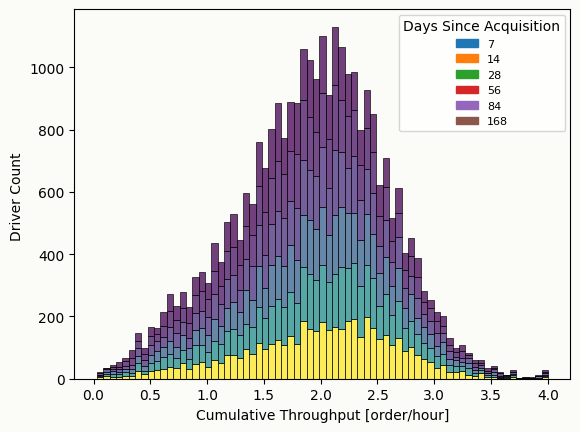

In [18]:
ax = sns.histplot(df_rgr, x="THROUGHPUT_CUMULATIVE", hue="DAYS_SINCE_ACQUISITION", multiple="stack", palette="viridis", fill=True)

# Manually create the legend
unique_values = sorted(df_rgr["DAYS_SINCE_ACQUISITION"].unique())  # Ensure sorted order for consistency
colors = sns.color_palette("tab10", len(unique_values))  # Generate colors

# Label Axis
ax.set(xlabel='Cumulative Throughput [order/hour]', ylabel='Driver Count ')

# Create custom legend patches
legend_patches = [Patch(color=colors[i], label=str(val)) for i, val in enumerate(unique_values)]

plt.gcf().set_facecolor('#fbfbf7')  
ax.set_facecolor('#fbfbf7')

# Add the legend
ax.legend(handles=legend_patches, title="Days Since Acquisition", loc="upper right", fontsize = 8)

In [19]:
stat, crit_values, sig_levels = stats.anderson(df_rgr["THROUGHPUT_CUMULATIVE"].dropna(), dist='norm')
print("Anderson-Darling Test Result:")
print(f"Test statistic: {stat}")
for i in range(len(crit_values)):
    print(f"Critical value at {sig_levels[i]}% significance: {crit_values[i]}")
if stat > crit_values[2]:  # Typically use 5% significance level (index 2)
    print("The data does not follow a normal distribution.")
else:
    print("The data follows a normal distribution.")

Anderson-Darling Test Result:
Test statistic: 48.3248086282656
Critical value at 15.0% significance: 0.576
Critical value at 10.0% significance: 0.656
Critical value at 5.0% significance: 0.787
Critical value at 2.5% significance: 0.918
Critical value at 1.0% significance: 1.092
The data does not follow a normal distribution.


**How has RGR performed? How does that compare with other channels?**

Let's get basic summary statistics

In [20]:
## Get driver master data
df_driver = df_rgr.drop_duplicates(subset=['RIDER_ID', 'APPLICATION_DATE', 'APPLICATION_APPROVED_DATE', 'FIRST_WORK_DATE', 'ACQUISITION_CHANNEL', 'VEHICLE_TYPE'])

# Check if distinct
duplicates = df_driver['RIDER_ID'].duplicated().sum()

print(f"Duplicate rider count: {duplicates}")

# Get count of Drivers
count_driver = (df_driver['RIDER_ID']).count()
print(f"Rider count: {count_driver}")


# Get count of Referrals
df_referrals = df_rgr.groupby('RIDER_ID')['REFERRALS_CUMULATIVE'].max()
count_referrals = df_referrals.sum()
print(f"Total Referral count: {count_referrals}")

# Get count of Successful Referrals
df_successful_referrals = df_rgr.groupby('RIDER_ID')['SUCCESSFUL_REFERRALS_CUMULATIVE'].max()
count_successful_referrals = df_successful_referrals.sum()
print(f"Total Succesful Referral count: {count_successful_referrals}")

# Count number of drivers who made a referral
count_driver_referrals = df_referrals.dropna().count()
print(f"Driver referral count: {count_driver_referrals}")

#Get ratio of successful to non succesful
# Group by 'RIDER_ID' and aggregate the maximum values for both successful and total referrals
df_referrals = df_rgr.groupby('RIDER_ID').agg(
    successful_referrals=('SUCCESSFUL_REFERRALS_CUMULATIVE', 'max'),
    total_referrals=('REFERRALS_CUMULATIVE', 'max')
).reset_index()

# Calculate the success ratio (successful referrals / total referrals)
df_referrals['success_ratio'] = df_referrals['successful_referrals'] / df_referrals['total_referrals']

# Calculate the average of the success ratio
average_success_ratio = df_referrals['success_ratio'].mean()

# Print the result
print(f"Average success ratio: {average_success_ratio}")



Duplicate rider count: 0
Rider count: 4917
Total Referral count: 3263.0
Total Succesful Referral count: 712.0
Driver referral count: 1227
Average success ratio: 0.2601960011458857


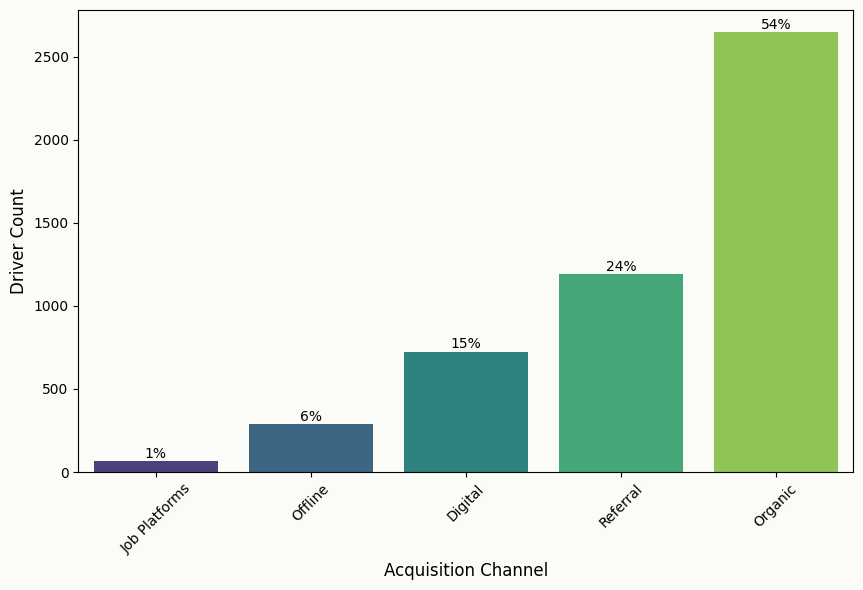

In [21]:
# Summarize ridercount cumulative across acquisition channels
series = df_driver.groupby('ACQUISITION_CHANNEL')['RIDER_ID'].count()

# Convert series to DataFrame
df = pd.DataFrame({'ACQUISITION_CHANNEL': series.index, 'RIDER_ID': series.values})
df = df.sort_values(by='RIDER_ID', ascending=True)

# Calculate total number of drivers
total_drivers = df['RIDER_ID'].sum()

# Calculate percentages for each acquisition channel
df['Percentage'] = (df['RIDER_ID'] / total_drivers) * 100

# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size
ax = sns.barplot(data=df, x='ACQUISITION_CHANNEL', y='RIDER_ID', hue="ACQUISITION_CHANNEL", palette="viridis")

# Add formatted percentage labels
for container in ax.patches:  # Loop through the bars
    height = container.get_height()  # Height of the bar (driver count)
    x_position = container.get_x() + container.get_width() / 2  # Center of the bar
    # Calculate the percentage based on height
    percentage = round((height / total_drivers) * 100)  # Round to the nearest unit
    ax.text(x_position, height + 0.5, f"{percentage}%", ha='center', va='bottom', fontsize=10)

# Customize axis labels and title
plt.xlabel("Acquisition Channel", fontsize=12)
plt.ylabel("Driver Count", fontsize=12)

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.gcf().set_facecolor('#fbfbf7')  
ax.set_facecolor('#fbfbf7')


# Show plot
plt.show()


In [22]:
# Group the 'RIDER_ID' counts by the 'ACQUISITION_CHANNEL'
grouped_data = [df_driver[df_driver['ACQUISITION_CHANNEL'] == channel]['RIDER_ID'].values for channel in df_driver['ACQUISITION_CHANNEL'].unique()]

# Perform the ANOVA
f_stat, p_value = stats.f_oneway(*grouped_data)

# Print the result
print(f"ANOVA F-statistic: {f_stat}")
print(f"ANOVA p-value: {p_value}")

ANOVA F-statistic: 9.502527246516237
ANOVA p-value: 1.1910793045580434e-07


Let's measure throughput

Overall Performance


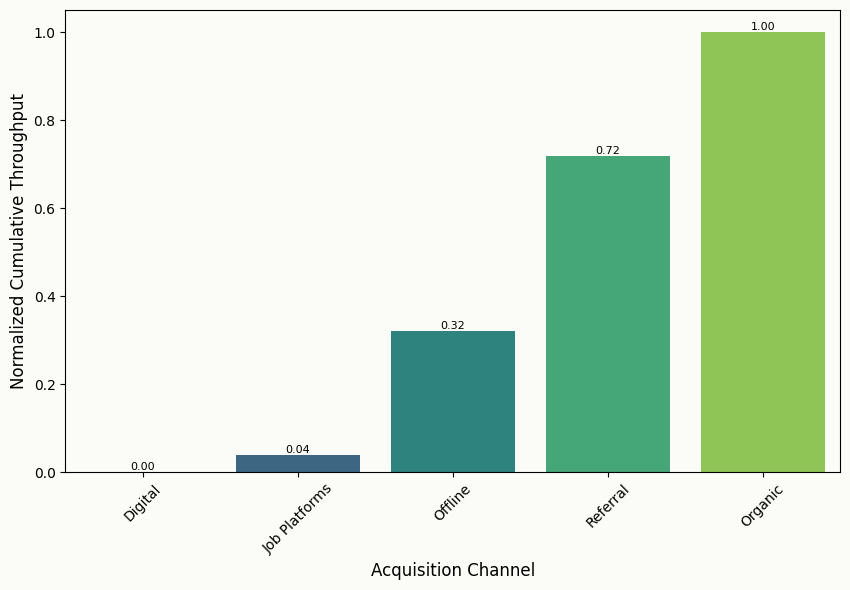

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler

# Summarize throughput cumulative across acquisition channels
print("Overall Performance")
series = df_rgr.groupby('ACQUISITION_CHANNEL')['THROUGHPUT_CUMULATIVE'].mean()

# Convert series to DataFrame
df = pd.DataFrame({'ACQUISITION_CHANNEL': series.index, 'THROUGHPUT_CUMULATIVE_mean': series.values})

# Normalize throughput cumulative (Min-Max Scaling)
scaler = MinMaxScaler()
df['THROUGHPUT_CUMULATIVE_mean_normalized'] = scaler.fit_transform(df[['THROUGHPUT_CUMULATIVE_mean']])

# Sort the DataFrame by the normalized values in ascending order
df = df.sort_values(by='THROUGHPUT_CUMULATIVE_mean_normalized', ascending=True)

# Create the bar plot using normalized values
plt.figure(figsize=(10, 6))  # Adjust figure size
ax = sns.barplot(data=df, x='ACQUISITION_CHANNEL', y='THROUGHPUT_CUMULATIVE_mean_normalized', hue="ACQUISITION_CHANNEL", palette="viridis")

# Add formatted value labels (rounded to 2 decimal places)
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", fontsize=8)

# Customize axis labels and title
plt.xlabel("Acquisition Channel", fontsize=12)
plt.ylabel("Normalized Cumulative Throughput", fontsize=12)

# Rotate x-axis labels 
plt.xticks(rotation=45)

# Customize plot background
plt.gcf().set_facecolor('#fbfbf7')  
ax.set_facecolor('#fbfbf7')

# Show plot
plt.show()


In [24]:

# Extracting values for each acquisition channel
digital = df_rgr.loc[df_rgr["ACQUISITION_CHANNEL"] == "Digital", "THROUGHPUT_CUMULATIVE"]
job_platform = df_rgr.loc[df_rgr["ACQUISITION_CHANNEL"] == "Job Platforms", "THROUGHPUT_CUMULATIVE"]
offline = df_rgr.loc[df_rgr["ACQUISITION_CHANNEL"] == "Offline", "THROUGHPUT_CUMULATIVE"]
organic = df_rgr.loc[df_rgr["ACQUISITION_CHANNEL"] == "Organic", "THROUGHPUT_CUMULATIVE"]
referral = df_rgr.loc[df_rgr["ACQUISITION_CHANNEL"] == "Referral", "THROUGHPUT_CUMULATIVE"]

# Performing one-way ANOVA
f_stat, p_value = stats.f_oneway(digital, job_platform, offline, organic, referral)

# Printing the results
print(f"ANOVA Test Statistic: {f_stat:.4f}, p-value: {p_value:.4f}")


ANOVA Test Statistic: 107.3187, p-value: 0.0000


In [25]:
model = ols('THROUGHPUT_CUMULATIVE ~ C(ACQUISITION_CHANNEL)', data=df_rgr).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

tukey = pairwise_tukeyhsd(df_rgr['THROUGHPUT_CUMULATIVE'], df_rgr['ACQUISITION_CHANNEL'])
print(tukey)

                              sum_sq       df           F        PR(>F)
C(ACQUISITION_CHANNEL)    182.012896      4.0  107.318713  6.104239e-91
Residual                12464.776508  29398.0         NaN           NaN
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
      Digital Job Platforms   0.0084 0.9992 -0.0855  0.1023  False
      Digital       Offline    0.069 0.0019  0.0184  0.1196   True
      Digital       Organic    0.215    0.0  0.1845  0.2454   True
      Digital      Referral   0.1542    0.0    0.12  0.1884   True
Job Platforms       Offline   0.0606 0.4602 -0.0391  0.1602  False
Job Platforms       Organic   0.2065    0.0  0.1155  0.2976   True
Job Platforms      Referral   0.1457 0.0002  0.0534  0.2381   True
      Offline       Organic    0.146    0.0  0.1009  0.1911   True
      Offline      Referral   0.0852    0.0  0.

Performance across time


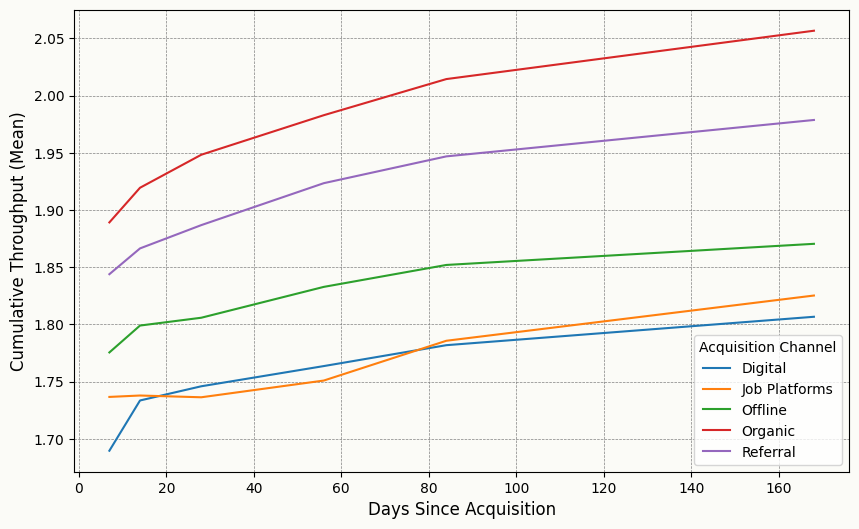

In [26]:
print("Performance across time")
series = df_rgr.groupby(['ACQUISITION_CHANNEL', 'DAYS_SINCE_ACQUISITION'])['THROUGHPUT_CUMULATIVE'].mean()
df = series.to_frame().reset_index()
df = df.rename(columns={'THROUGHPUT_CUMULATIVE': 'THROUGHPUT_CUMULATIVE_mean'})

# Customizing the plot
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

# Create the line plot
ax = sns.lineplot(
    data=df, 
    x='DAYS_SINCE_ACQUISITION', 
    y='THROUGHPUT_CUMULATIVE_mean', 
    hue="ACQUISITION_CHANNEL",
    palette="tab10"  # Change the color palette
)

# Set background color for the entire plot (area behind the plot)
plt.gcf().set_facecolor('#fbfbf7')  # Set figure background
ax.set_facecolor('#fbfbf7')  # Set the axis (grid) background color

# Enable grid and set its appearance
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')  # Grid style
ax.set_axisbelow(True)  # Ensure the grid is behind the lines

# Customizing labels and legend
plt.xlabel("Days Since Acquisition", fontsize=12)
plt.ylabel("Cumulative Throughput (Mean)", fontsize=12)
plt.legend(title="Acquisition Channel", loc="lower right")  # Adjust position as needed

# Show the plot
plt.show()


To make things simpler, I think I will categorise all channels as either 'RGR' or 'Other

In [27]:
df_rgr = df_rgr.copy()  # Prevents chained assignment warning
df_rgr.loc[:, 'RGR_LABEL'] = np.where(df_rgr['ACQUISITION_CHANNEL'] == 'Referral', 'RGR', 'Other')


In [28]:
df_rgr['DAYS_SINCE_ACQUISITION'].unique()

array([  7,  14,  28,  56,  84, 168])

In [29]:
# Get unique riders who reached at least 7 days
riders_at_56 = df_rgr[df_rgr['DAYS_SINCE_ACQUISITION'] >= 56].groupby('RGR_LABEL')['RIDER_ID'].nunique()

# Get unique riders who made it past 7 days (i.e., 14 days or more)
riders_past_56 = df_rgr[df_rgr['DAYS_SINCE_ACQUISITION'] > 56].groupby('RGR_LABEL')['RIDER_ID'].nunique()

# Calculate percentage retention
retention_rate = (riders_past_56 / riders_at_56) * 100

# Create a DataFrame for readability
retention_df = pd.DataFrame({
    'Riders at 56 Days': riders_at_56,
    'Riders Past 56 Days': riders_past_56,
    'Retention Rate (%)': retention_rate
}).reset_index()

# Display results
print(retention_df)


  RGR_LABEL  Riders at 56 Days  Riders Past 56 Days  Retention Rate (%)
0     Other               3726                 3726               100.0
1       RGR               1191                 1191               100.0


In [30]:
import pandas as pd

# Assuming df_rgr is your DataFrame
df_rgr['FIRST_WORK_DATE'] = pd.to_datetime(df_rgr['FIRST_WORK_DATE'])  # Ensure the first work date is in datetime format
df_rgr['YEAR'] = df_rgr['FIRST_WORK_DATE'].dt.year  # Extract the year from the first work date

# Filter the data for RGR_LABEL = 'RGR'
df_rgr_rgr = df_rgr[df_rgr['RGR_LABEL'] == 'RGR']

# Count the distinct RIDER_ID for each year
rgr_yearly_count = df_rgr_rgr.groupby('YEAR')['RIDER_ID'].nunique().reset_index()

# Rename the column for clarity
rgr_yearly_count = rgr_yearly_count.rename(columns={'RIDER_ID': 'NUM_RGR_DRIVERS'})

# Print the results
print(rgr_yearly_count)


   YEAR  NUM_RGR_DRIVERS
0  2016              724
1  2017              467


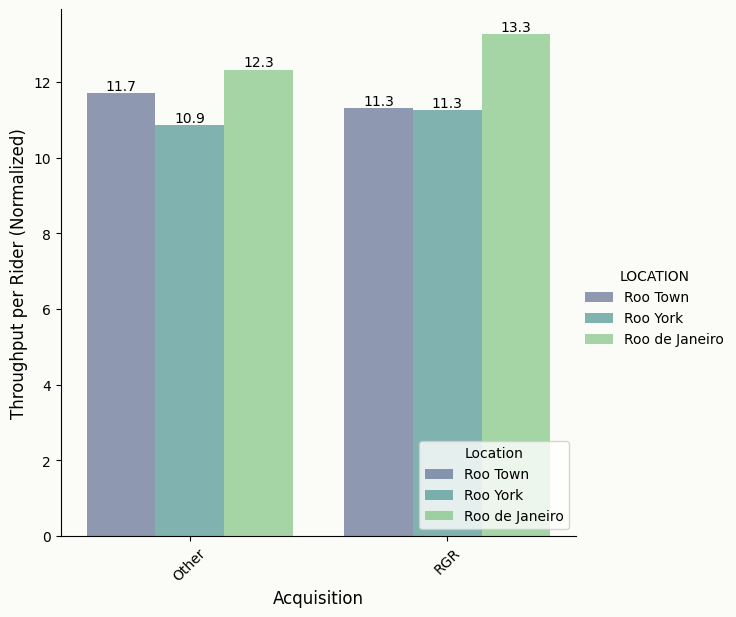

In [31]:


# Count unique riders per group
rider_counts = df_rgr.groupby(['RGR_LABEL', 'LOCATION'])['RIDER_ID'].nunique()

# Sum total throughput per group
total_throughput = df_rgr.groupby(['RGR_LABEL', 'LOCATION'])['THROUGHPUT_CUMULATIVE'].sum()

# Compute normalized throughput (throughput per rider)
df_norm = (total_throughput / rider_counts).reset_index()
df_norm = df_norm.rename(columns={0: 'THROUGHPUT_PER_RIDER'})

# Plot the normalized throughput
g = sns.catplot(
    data=df_norm, kind='bar',
    x='RGR_LABEL', y='THROUGHPUT_PER_RIDER', hue='LOCATION', palette='viridis', alpha=.6, height=6
)

# Extract the matplotlib axes_subplot object from FacetGrid
ax = g.facet_axis(0, 0)

# Iterate through the axes containers and add labels
for c in ax.containers:
    labels = [f'{v.get_height():.1f}' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

# Customizing labels and legend
plt.xlabel("Acquisition", fontsize=12)
plt.ylabel("Throughput per Rider (Normalized)", fontsize=12)
plt.legend(title="Location", loc="lower right")  # Adjust position as needed

# Rotate x-axis labels 
plt.xticks(rotation=45)

plt.gcf().set_facecolor('#fbfbf7')  
ax.set_facecolor('#fbfbf7')

plt.show()




More difference! Let us see if location is significant.

In [32]:
model = ols('THROUGHPUT_CUMULATIVE ~ C(RGR_LABEL) * C(LOCATION)', data=df_rgr).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                                sum_sq       df           F         PR(>F)
C(RGR_LABEL)                 26.363714      1.0   62.930502   2.216895e-15
C(LOCATION)                 326.609191      2.0  389.810027  8.195769e-168
C(RGR_LABEL):C(LOCATION)      4.691830      2.0    5.599727   3.702821e-03
Residual                  12315.396878  29397.0         NaN            NaN


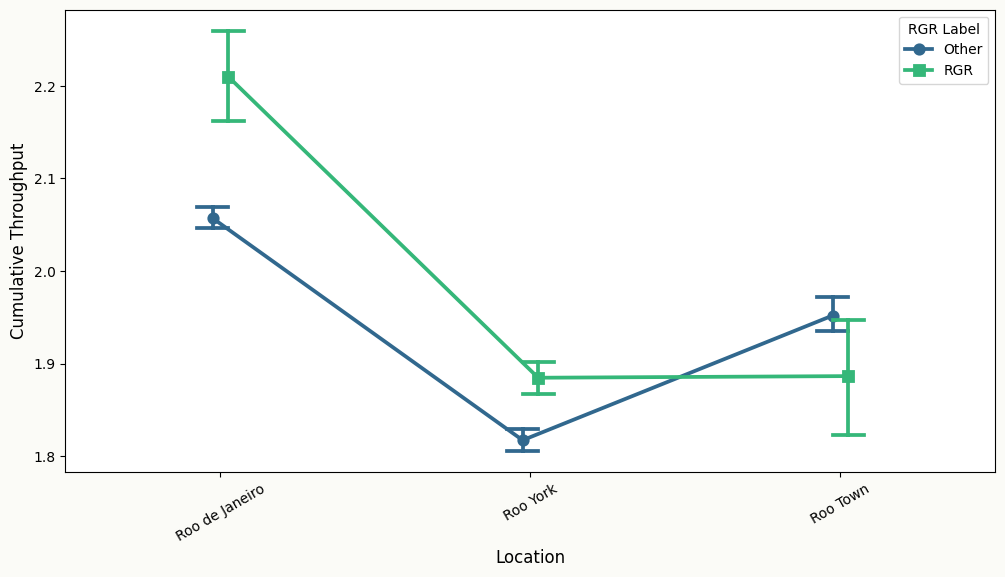

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot interaction between RGR_LABEL and VEHICLE_TYPE
plt.figure(figsize=(12, 6))
sns.pointplot(
    data=df_rgr, x='LOCATION', y='THROUGHPUT_CUMULATIVE',
    hue='RGR_LABEL', dodge=True, markers=['o', 's', 'D', '^', 'v'],
    capsize=0.1, palette='viridis'
)

plt.xlabel("Location", fontsize=12)
plt.ylabel("Cumulative Throughput", fontsize=12)
plt.xticks(rotation=30)
plt.legend(title="RGR Label")
# Set background color
plt.gcf().set_facecolor('#fbfbf7')  
ax.set_facecolor('#fbfbf7')
plt.show()


In [34]:
import statsmodels.stats.multicomp as mc

# Tukey HSD for interaction
tukey_interaction = mc.pairwise_tukeyhsd(df_rgr['THROUGHPUT_CUMULATIVE'], 
                                         df_rgr['RGR_LABEL'].astype(str) + " - " + df_rgr['LOCATION'].astype(str), 
                                         alpha=0.05)
print(tukey_interaction)

                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                 group2         meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------
      Other - Roo Town       Other - Roo York  -0.1346    0.0 -0.1821 -0.0871   True
      Other - Roo Town Other - Roo de Janeiro   0.1051    0.0  0.0559  0.1543   True
      Other - Roo Town         RGR - Roo Town  -0.0654 0.9456 -0.2715  0.1407  False
      Other - Roo Town         RGR - Roo York  -0.0672 0.0019 -0.1173 -0.0171   True
      Other - Roo Town   RGR - Roo de Janeiro   0.2581    0.0  0.1646  0.3515   True
      Other - Roo York Other - Roo de Janeiro   0.2397    0.0  0.2132  0.2662   True
      Other - Roo York         RGR - Roo Town   0.0692 0.9254 -0.1327  0.2711  False
      Other - Roo York         RGR - Roo York   0.0674    0.0  0.0394  0.0955   True
      Other - Roo York   RGR - Roo de Janeiro   0.3927    0.0  0.

It seems as though Roo Town is not significant. With the data it is limited to understand why. I am going to see if it is a result of low riders.

Indicates that location is significant - let's see for number of drivers

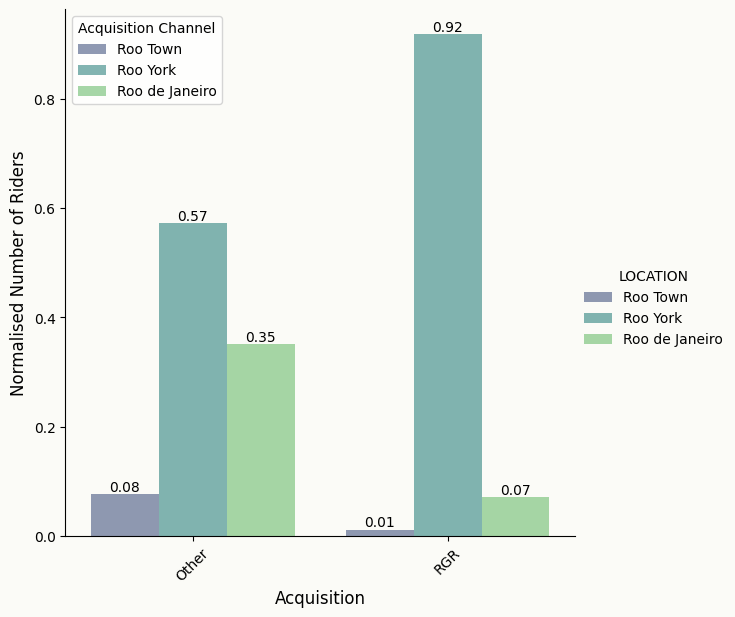

In [35]:
# Grouping by 'RGR_LABEL' and 'LOCATION' to count unique 'RIDER_ID'
rider_count = df_rgr.groupby(['RGR_LABEL', 'LOCATION'])['RIDER_ID'].nunique()

# Convert to DataFrame and reset index
df = rider_count.to_frame().reset_index()
df = df.rename(columns={'RIDER_ID': 'NUMBER_OF_RIDERS'})

# Calculate the total number of riders for each 'RGR_LABEL'
total_riders = df.groupby('RGR_LABEL')['NUMBER_OF_RIDERS'].transform('sum')

# Normalize by dividing by the total number of riders per 'RGR_LABEL'
df['NORMALIZED_RIDERS'] = df['NUMBER_OF_RIDERS'] / total_riders

# Create a bar plot using seaborn for the normalized data
g = sns.catplot(
    data=df, kind='bar',
    x='RGR_LABEL', y='NORMALIZED_RIDERS', hue='LOCATION', palette='viridis', alpha=.6, height=6
)

# Extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

# Iterate through the axes containers to add labels on top of bars
for c in ax.containers:
    labels = [f'{v.get_height():.2f}' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

# Customizing labels and legend
plt.xlabel("Acquisition", fontsize=12)
plt.ylabel("Normalised Number of Riders", fontsize=12)
plt.legend(title="Acquisition Channel", loc="upper left")  # Adjust position as needed

# Rotate x-axis labels 
plt.xticks(rotation=45)

# Set background color
plt.gcf().set_facecolor('#fbfbf7')  
ax.set_facecolor('#fbfbf7')

# Show plot
plt.show()


In [36]:

# Iterate through each unique LOCATION
for location in df_rgr['LOCATION'].unique():
    print(f"\nStatistical test for LOCATION: {location}")

    # Subset data for this LOCATION
    data_location = df_rgr[df_rgr['LOCATION'] == location]
    
    # Split data into two groups: RGR vs Other
    rgr_data = data_location[data_location['RGR_LABEL'] == 'RGR']['THROUGHPUT_CUMULATIVE']
    other_data = data_location[data_location['RGR_LABEL'] == 'Other']['THROUGHPUT_CUMULATIVE']
    
    # Check if we have enough data for both groups
    if len(rgr_data) < 2 or len(other_data) < 2:
        print("Not enough data for statistical testing in this location.")
        continue
    
    # Perform an independent t-test (assuming normality)
    t_stat, p_val = ttest_ind(rgr_data, other_data, equal_var=False)  # Welch’s t-test (does not assume equal variance)
    print(f"t-test: t-statistic = {t_stat:.3f}, p-value = {p_val:.5f}")

    # Perform a Mann-Whitney U test (non-parametric alternative)
    u_stat, p_val_mw = mannwhitneyu(rgr_data, other_data, alternative='two-sided')
    print(f"Mann-Whitney U test: U-statistic = {u_stat:.3f}, p-value = {p_val_mw:.5f}")

    # Interpretation
    if p_val < 0.05:
        print(" → The mean throughput is significantly different between RGR and Other (t-test).")
    else:
        print(" → No significant difference in throughput between RGR and Other (t-test).")

    if p_val_mw < 0.05:
        print(" → The throughput distribution is significantly different between RGR and Other (Mann-Whitney U test).")
    else:
        print(" → No significant difference in throughput distribution between RGR and Other (Mann-Whitney U test).")



Statistical test for LOCATION: Roo de Janeiro
t-test: t-statistic = 6.183, p-value = 0.00000
Mann-Whitney U test: U-statistic = 2244248.000, p-value = 0.00000
 → The mean throughput is significantly different between RGR and Other (t-test).
 → The throughput distribution is significantly different between RGR and Other (Mann-Whitney U test).

Statistical test for LOCATION: Roo York
t-test: t-statistic = 6.198, p-value = 0.00000
Mann-Whitney U test: U-statistic = 43706148.500, p-value = 0.00000
 → The mean throughput is significantly different between RGR and Other (t-test).
 → The throughput distribution is significantly different between RGR and Other (Mann-Whitney U test).

Statistical test for LOCATION: Roo Town
t-test: t-statistic = -1.951, p-value = 0.05384
Mann-Whitney U test: U-statistic = 63362.000, p-value = 0.06805
 → No significant difference in throughput between RGR and Other (t-test).
 → No significant difference in throughput distribution between RGR and Other (Mann-Whi

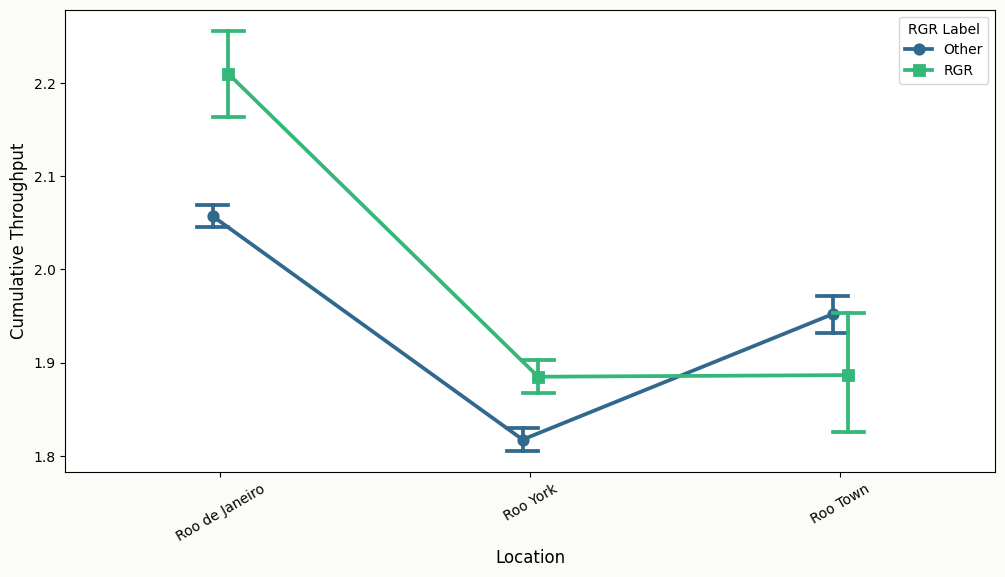

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot interaction between RGR_LABEL and VEHICLE_TYPE
plt.figure(figsize=(12, 6))
sns.pointplot(
    data=df_rgr, x='LOCATION', y='THROUGHPUT_CUMULATIVE',
    hue='RGR_LABEL', dodge=True, markers=['o', 's', 'D', '^', 'v'],
    capsize=0.1, palette='viridis'
)

plt.xlabel("Location", fontsize=12)
plt.ylabel("Cumulative Throughput", fontsize=12)
plt.xticks(rotation=30)
plt.legend(title="RGR Label")
# Set background color
plt.gcf().set_facecolor('#fbfbf7')  
ax.set_facecolor('#fbfbf7')
plt.show()


In [38]:
import statsmodels.stats.multicomp as mc

# Tukey HSD for interaction
tukey_interaction = mc.pairwise_tukeyhsd(df_rgr['THROUGHPUT_CUMULATIVE'], 
                                         df_rgr['RGR_LABEL'].astype(str) + " - " + df_rgr['LOCATION'].astype(str), 
                                         alpha=0.05)
print(tukey_interaction)


                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                 group2         meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------
      Other - Roo Town       Other - Roo York  -0.1346    0.0 -0.1821 -0.0871   True
      Other - Roo Town Other - Roo de Janeiro   0.1051    0.0  0.0559  0.1543   True
      Other - Roo Town         RGR - Roo Town  -0.0654 0.9456 -0.2715  0.1407  False
      Other - Roo Town         RGR - Roo York  -0.0672 0.0019 -0.1173 -0.0171   True
      Other - Roo Town   RGR - Roo de Janeiro   0.2581    0.0  0.1646  0.3515   True
      Other - Roo York Other - Roo de Janeiro   0.2397    0.0  0.2132  0.2662   True
      Other - Roo York         RGR - Roo Town   0.0692 0.9254 -0.1327  0.2711  False
      Other - Roo York         RGR - Roo York   0.0674    0.0  0.0394  0.0955   True
      Other - Roo York   RGR - Roo de Janeiro   0.3927    0.0  0.

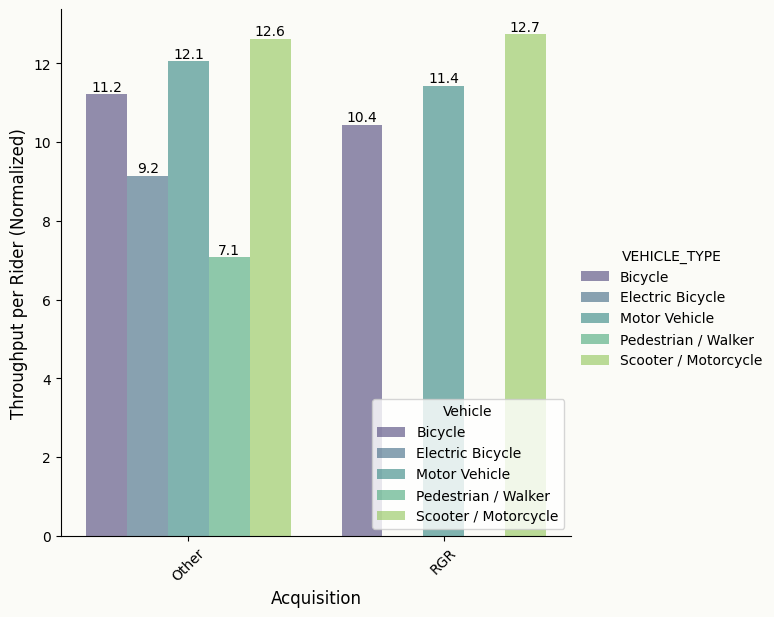

In [39]:


# Count unique riders per group
rider_counts = df_rgr.groupby(['RGR_LABEL', 'VEHICLE_TYPE'])['RIDER_ID'].nunique()

# Sum total throughput per group
total_throughput = df_rgr.groupby(['RGR_LABEL', 'VEHICLE_TYPE'])['THROUGHPUT_CUMULATIVE'].sum()

# Compute normalized throughput (throughput per rider)
df_norm = (total_throughput / rider_counts).reset_index()
df_norm = df_norm.rename(columns={0: 'THROUGHPUT_PER_RIDER'})

# Plot the normalized throughput
g = sns.catplot(
    data=df_norm, kind='bar',
    x='RGR_LABEL', y='THROUGHPUT_PER_RIDER', hue='VEHICLE_TYPE', palette='viridis', alpha=.6, height=6
)

# Extract the matplotlib axes_subplot object from FacetGrid
ax = g.facet_axis(0, 0)

# Iterate through the axes containers and add labels
for c in ax.containers:
    labels = [f'{v.get_height():.1f}' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

# Customizing labels and legend
plt.xlabel("Acquisition", fontsize=12)
plt.ylabel("Throughput per Rider (Normalized)", fontsize=12)
plt.legend(title="Vehicle", loc="lower right")  # Adjust position as needed

# Rotate x-axis labels 
plt.xticks(rotation=45)

plt.gcf().set_facecolor('#fbfbf7')  
ax.set_facecolor('#fbfbf7')

plt.show()




In [40]:
# Low volume of certain groups, will have to remove for proper analysis
df = df_rgr.groupby(['RGR_LABEL', 'VEHICLE_TYPE']).filter(lambda x: len(x) > 1)

df['RGR_LABEL'] = df['RGR_LABEL'].astype('category')
df['VEHICLE_TYPE'] = df['VEHICLE_TYPE'].astype('category')

# Step 1: Run ANOVA to check if significant differences exist
model = ols('THROUGHPUT_CUMULATIVE ~ C(RGR_LABEL) + C(VEHICLE_TYPE)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                       sum_sq       df           F         PR(>F)
C(RGR_LABEL)        33.757983      1.0   81.060007   2.318442e-19
C(VEHICLE_TYPE)    404.120248      4.0  242.594396  2.296221e-205
Residual         12242.577650  29397.0         NaN            NaN


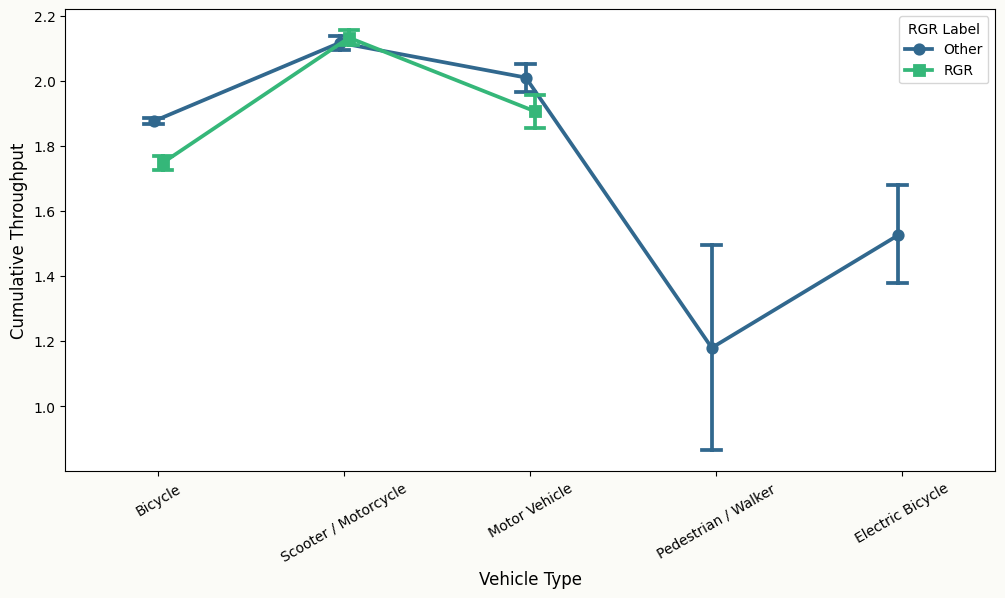

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot interaction between RGR_LABEL and VEHICLE_TYPE
plt.figure(figsize=(12, 6))
sns.pointplot(
    data=df_rgr, x='VEHICLE_TYPE', y='THROUGHPUT_CUMULATIVE',
    hue='RGR_LABEL', dodge=True, markers=['o', 's', 'D', '^', 'v'],
    capsize=0.1, palette='viridis'
)

plt.xlabel("Vehicle Type", fontsize=12)
plt.ylabel("Cumulative Throughput", fontsize=12)
plt.xticks(rotation=30)
plt.legend(title="RGR Label")
# Set background color
plt.gcf().set_facecolor('#fbfbf7')  
ax.set_facecolor('#fbfbf7')
plt.show()


In [42]:
import statsmodels.stats.multicomp as mc

# Tukey HSD for interaction
tukey_interaction = mc.pairwise_tukeyhsd(df_rgr['THROUGHPUT_CUMULATIVE'], 
                                         df_rgr['RGR_LABEL'].astype(str) + " - " + df_rgr['VEHICLE_TYPE'].astype(str), 
                                         alpha=0.05)
print(tukey_interaction)


                      Multiple Comparison of Means - Tukey HSD, FWER=0.05                       
           group1                       group2            meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------------
             Other - Bicycle     Other - Electric Bicycle  -0.3507 0.5624 -0.9151  0.2137  False
             Other - Bicycle        Other - Motor Vehicle    0.134   0.03  0.0071   0.261   True
             Other - Bicycle  Other - Pedestrian / Walker  -0.6957 0.0046 -1.2601 -0.1313   True
             Other - Bicycle Other - Scooter / Motorcycle   0.2407    0.0  0.2037  0.2777   True
             Other - Bicycle                RGR - Bicycle  -0.1272    0.0 -0.1607 -0.0937   True
             Other - Bicycle          RGR - Motor Vehicle   0.0301    1.0 -0.5342  0.5945  False
             Other - Bicycle   RGR - Scooter / Motorcycle   0.2563    0.0  0.2176   0.295   True
    Other - Electric Bicycle  